In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 6
fig_height = 4
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/Users/hirofumi48/162348.github.io/posts/2024/Process"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
using ZigZagBoomerang
using SparseArrays

d = 2

# 対数尤度関数 ϕ の第 i 成分に関する微分を計算
Γ = sparse([1,1,2,2], [1,2,1,2], [2.0,-1.0,-1.0,2.0])  # <1>
∇ϕ(x, i, Γ) = ZigZagBoomerang.idot(Γ, i, x)  # <2>

# 初期値
t0 = 0.0
x0 = randn(d)
θ0 = rand([-1.0,1.0], d)

# Rejection bounds
c = 1.0 * ones(length(x0))

# ZigZag 過程をインスタンス化
Z = ZigZag(Γ, x0*0)

# シミュレーション実行
T = 20.0
@time zigzag_trace, (tT, xT, θT), (acc, num) = spdmp(∇ϕ, t0, x0, θ0, T, c, Z, Γ; adapt=true)

# 軌跡を離散化
@time traj = collect(discretize(zigzag_trace, 0.1))

# 結果の表示
println("Final state: ", xT)
println("Trajectory length: ", length(traj))

  0.980705 seconds (2.94 M allocations: 195.001 MiB, 3.03% gc time, 99.95% compilation time)
  0.042733 seconds (127.01 k allocations: 8.579 MiB, 15.08% gc time, 99.88% compilation time)
Final state: 

[-0.58275161978642, -1.1936384414035184]
Trajectory length: 206


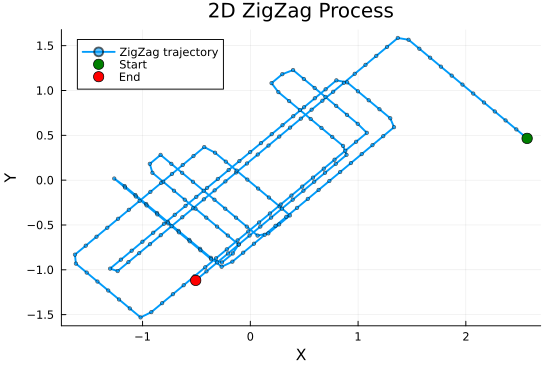

In [3]:
using Plots

# trajからx座標とy座標を抽出
x_coords = [state[1] for (t, state) in traj]
y_coords = [state[2] for (t, state) in traj]

# 軌跡のプロット
p = plot(x_coords, y_coords, 
         label="ZigZag trajectory",
         title="2D ZigZag Process",
         xlabel="X",
         ylabel="Y",
         linewidth=2,
         marker=:circle,
         markersize=2,
         markeralpha=0.6)

# 開始点と終了点をマーク
scatter!([x_coords[1]], [y_coords[1]], label="Start", color=:green, markersize=6)
scatter!([x_coords[end]], [y_coords[end]], label="End", color=:red, markersize=6)

# プロットを表示
display(p)

In [4]:
using ZigZagBoomerang, Distributions, ForwardDiff, LinearAlgebra, SparseArrays, StructArrays
const ZZB = ZigZagBoomerang
## Problem
d = 2
n = 10
xtrue = [-3.0, 3.0]
data = rand(Normal(xtrue[1], xtrue[2]), n)
g(x) = sum(logpdf(Normal(x[1], x[2]), dt) for dt in data) 

## Negative partial derivative maker
function negpartiali(f, d)
   id = collect(I(d))
   ith = [id[:,i] for i in 1:d]
   function (x, i, args...)
       sa = StructArray{ForwardDiff.Dual{}}((x, ith[i]))
       δ = -f(sa, args...).partials[]
       return δ
   end
end

## Sampler

# Starting point
t0 = 0.0
x0 = [2.0, 5.0]
θ0 = rand([-1.0,1.0], d)
u0 = ZZB.stickystate(x0)

# Dynamics
Z = ZigZag(sparse(I(n)), x0*0);
flow = ZZB.StickyFlow(Z)

# Duration
T = 2000.0
end_time = ZZB.EndTime(T)


# Target 
G = [i=>collect(1:d) for i in 1:d] # Sparsity target (full)
target = ZZB.StructuredTarget(G, negpartiali(g, d))

# Barriers
c = 1.0*ones(length(x0))
κ = Inf # Inverse waiting time
barriers = [ZZB.StickyBarriers(), # No barrier
            ZZB.StickyBarriers((2.5, Inf), (:reflect, :reflect), (κ, κ)) # instantaneously reflect at 0 and at "infinity"
   ]

# Rejection bounds
strong = false
c = 20*[1.0 for i in 1:d]
adapt = true # adapt bounds
multiplier = 1.5
G1 = [i => [i] for i in 1:d] # Sparsity pattern bounds (diagonal)
upper_bounds = ZZB.StickyUpperBounds(G, G1, 1.0sparse(I(d)), c; adapt=adapt, strong=strong, multiplier= multiplier)
  
# Sample
zigzag_trace, _, _, acc = @time ZZB.stickyzz(u0, target, flow, upper_bounds, barriers, end_time)
println("acc ", acc.acc/acc.num)

# Discretize on dynamic grid for plotting
@time ts1, xs1 = ZZB.sep(collect(zigzag_trace))

# Discretize on fixed grid for means
dt = 0.5
ts, xs = ZZB.sep(collect(discretize(zigzag_trace, dt)))
@show mean(xs)


# Visualize
using GLMakie
fig1 = fig = Figure()
r = 1:length(ts1)
ax = Axis(fig[1,1], title = "zigzag_trace 1")
lines!(ax, ts1[r], getindex.(xs1[r], 1))
ax = Axis(fig[2,1], title = "zigzag_trace 2")
lines!(ax, ts1[r], getindex.(xs1[r], 2))

ax = Axis(fig[1:2,2], title = "phase")
lines!(ax, getindex.(xs1[r], 1), getindex.(xs1[r], 2))

# save(joinpath(@__DIR__, "positivity.png"), fig1)
display(fig1)

  0.367968 seconds (2.22 M allocations: 109.490 MiB, 2.63% gc time, 87.43% compilation time)
acc 0.018385954336523246
  0.039771 seconds (92.15 k allocations: 6.167 MiB, 99.75% compilation time)
mean(xs) = 

[-1.2007549647070723, 4.2353028756144235]


GLMakie.Screen(...)